In [1]:
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
# import yasa
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pyriemann.estimation import Covariances
# from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
import pickle as pkl
from tqdm import tqdm
from copy import deepcopy

from data_util import (
    load_subjects,
    load_subject_data,
    load_data,
    euclidean_alignment,
    label_alignment,
    np_standardize,
)

from fbcsp import FBCSP

In [2]:
data_dir = "../data/vin/Official"

In [47]:
# %%time
# fmt: off

subjects = [
    'K299', 'K300', 
    'K309', 'K310', 'K311', 'K312', 'K313', 
    'K314', 'K315', 'K316', 'K318', 'K319', 
    'K320', 'K321', 'K322', 'K323', 'K324', 
    'K325', 'K326', 'K327', 'K328', 'K329', 
    'K330', 'K331', 'K332', 'K333', 'K334', 
    'K335', 'K336', 'K337', 'K338', 'K339', 
    'K340', 'K342', 'K343', 'K344', 'K350', 
    'K351', 'K352', 'K353', 'K354', 'K355', 
    'K356', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K363', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = [
    'K300', 'K309', 'K311', 'K312', 'K313', 
    'K314', 'K315', 'K316', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K327', 
    'K328', 'K329', 'K332', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K354', 'K355', 
    'K358', 'K359', 'K360', 'K361', 'K362', 
    'K364', 'K366', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = [
    'K300', 'K309', 'K311', 'K312', 'K313', 
    'K314', 'K315', 'K316', 'K320', 'K321', 
    'K322', 'K324', 'K325', 'K326', 'K327', 
    'K328', 'K329', 'K331', 'K332', 'K335', 
    'K336', 'K337', 'K338', 'K339', 'K340', 
    'K354', 'K355', 'K357', 'K358', 'K359', 
    'K361', 'K362', 'K366', 'K367', 'K368', 
    'K369', 'K370', 'K371', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
#     "há miệng",
]

events = [
    "Thinking",
#     "Thinking and Acting",
    # "Resting",
    # "Typing",
]

# channels = [
#     "Fp1", "Fp2",
#     "F7", "F3", "Fz", "F4", "F8",
#     "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
#     "T7", "C3", "Cz", "C4", "T8",
#     "CP5", "CP1", "CP2", "CP6",
#     "P7", "P3", "Pz", "P4", "P8",
#     "PO9", "O1", "Oz", "O2", "PO10",
# ]
channels = [
   # "F7", "F3", "Fz", "F4", "F8",
   "FC5", "FC1", "FC2", "FC6",
   "C3", "Cz", "C4",
   "CP5", "CP1", "CP2", "CP6",
   # "P7", "P3", "Pz", "P4", "P8",
]

label_mapping={
#     "nâng tay trái_Thinking": "mi",
#     "nâng tay phải_Thinking": "mi",
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
#     "nâng tay trái_Thinking": "nâng tay",
#     "nâng tay phải_Thinking": "nâng tay",
#     "nâng chân trái_Thinking": "mi",
#     "nâng chân phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
#     "gật đầu_Thinking": "mi",
#     "lắc đầu_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "nâng tay trái_Thinking and Acting": "other",
    # "nâng tay phải_Thinking and Acting": "other",
    # "nâng chân trái_Thinking and Acting": "other",
    # "nâng chân phải_Thinking and Acting": "other",
    # "gật đầu_Thinking and Acting": "other",
    # "lắc đầu_Thinking and Acting": "other",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.25  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

ds = load_data(
    "../data/vin/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    epoch_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

for _ds in ds.datasets:
    _ds_info = _ds.description
    if _ds_info["subject"] == "K314":
        _ds_info["subject"] = "K314_t1"
    elif _ds_info["subject"] == "K324":
        _ds_info["subject"] = "K314_t2"

# filt_ds = load_data(
#     "../data/vin/Official",  
#     subjects=subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     epoch_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# for _ds in filt_ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description
# fmt: on

using 11 channels


subject:  70%|███████   | 71/101 [00:02<00:01, 22.58it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  77%|███████▋  | 78/101 [00:03<00:01, 19.48it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.

In [48]:
ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

ds_info

,subject,scenario,event,label,trial,split,epochs
0,K299,nâng tay trái,Thinking,nâng tay trái,0,train,16
1,K299,nâng tay trái,Thinking,nâng tay trái,1,train,14
2,K299,nâng tay trái,Thinking,nâng tay trái,2,train,20
3,K299,nâng tay phải,Thinking,nâng tay phải,0,train,11
4,K299,nâng tay phải,Thinking,nâng tay phải,1,train,18
...,...,...,...,...,...,...,...
741,K375,nâng chân trái,Thinking,nâng chân trái,1,train,19
742,K375,nâng chân trái,Thinking,nâng chân trái,2,train,21
743,K375,nâng chân phải,Thinking,nâng chân phải,0,train,22
744,K375,nâng chân phải,Thinking,nâng chân phải,1,train,20


In [9]:
ds_info[ds_info["subject"] == "K314"]

,subject,scenario,event,label,trial,split,epochs


In [30]:
aligned_ds = deepcopy(ds)
euclidean_alignment(aligned_ds, target_subject=None, labeled_trials=None)

exp_subjects = list()
acc = list()
f1 = list()
# for subject in [
#                 'K309', 'K311', 'K312', 'K313', 'K315', 
#                 'K321', 'K314_t2', 'K325', 'K328', 'K336', 
#                 'K338', 'K339', 'K354', 'K359', 'K362', 
#                 'K366', 'K368', 'K369', 'K370', 'K373',
#                 ]:
for subject in subjects:
    if subject.startswith("ALS"):
        continue
    if subject == "K314":
        subject = "K314_t1"
    elif subject == "K324":
        subject = "K314_t2"
    
    print(f"subject {subject}")
    exp_subjects.append(subject)
    
    ##################load data#######################
    
    # aligned_ds = deepcopy(ds)
    # euclidean_alignment(aligned_ds, target_subject=None, labeled_trials=None)
    
    Xtrain = list()
    Ytrain = list()
    Xvalid = list()
    Yvalid = list()
    for _ds in aligned_ds.datasets:
        _ds_info = _ds.description
        if _ds_info["subject"] == subject:
            if _ds_info["trial"] > 0:
                Xvalid.append(_ds.windows.get_data())
                Yvalid.extend(_ds.y)
            else:
                Xtrain.append(_ds.windows.get_data())
                Ytrain.extend(_ds.y)
        else:
            Xtrain.append(_ds.windows.get_data())
            Ytrain.extend(_ds.y)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    Xvalid = np.concatenate(Xvalid, axis=0)
    Yvalid = np.array(Yvalid, dtype=int)
    
    print(Xtrain.shape, np.bincount(Ytrain), Xvalid.shape, np.bincount(Yvalid))

    ################train model#######################
    
    # clf = make_pipeline(
    #     Covariances("cov"),
    #     TSclassifier(
    #         metric="riemann",
    #         clf=SVC(
    #             C=1.0,
    #             kernel="rbf",
    #             tol=1e-7,
    #             max_iter=30000,
    #             class_weight="balanced",
    #             random_state=42,
    #         ),
    #         # clf=LinearDiscriminantAnalysis(
    #         #     solver="lsqr",
    #         #     shrinkage="auto",
    #         #     n_components=None,
    #         #     tol=1e-7,
    #         #     covariance_estimator=None,
    #         # ),
    #     ),
    # )

    clf = make_pipeline(
        # FBCSP(
        #     filters=[(8, 12), (10, 14), (14, 18), (18, 22), (22, 26), (26, 30)],
        #     # filters=[(i, i + 2) for i in range(8, 30, 2)],
        #     filter_order=5,
        #     sfreq=128.0,
        #     n_components=4,
        #     # reg="ledoit_wolf",
        #     log=True,
        #     norm_trace=False,
        # ),
        mne.decoding.CSP(
            n_components=8,
            # reg="ledoit_wolf",
            log=True,
            norm_trace=False,
        ),
        # SVC(
        #     C=1.0,
        #     kernel="rbf",
        #     tol=1e-7,
        #     max_iter=30000,
        #     class_weight="balanced",
        #     random_state=42,
        # ),
        LinearDiscriminantAnalysis(
            solver="lsqr",
            shrinkage="auto",
            n_components=None,
            tol=1e-7,
            covariance_estimator=None,
        ),
    )

    clf.fit(Xtrain, Ytrain)
    
    ##################evaluate model#######################

    y_pred = clf.predict(Xvalid)
    
    sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
    sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')
    acc.append(sub_acc)
    f1.append(sub_f1)
    
    print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
    print()
    print(f"accuracy:\t{sub_acc}")
    print(f"f1_weighted:\t{sub_f1}")
    
    # break

subject: 100%|██████████| 44/44 [00:01<00:00, 42.87it/s]


subject K300
(11725, 11, 256) [2930 2953 2924 2918] (175, 11, 256) [28 40 33 74]
report:
              precision    recall  f1-score   support

           0       0.39      0.68      0.49        28
           1       0.73      0.60      0.66        40
           2       0.54      0.39      0.46        33
           3       0.93      0.86      0.90        74

    accuracy                           0.69       175
   macro avg       0.65      0.63      0.63       175
weighted avg       0.72      0.69      0.69       175

confusion matrix:
[[19  6  3  0]
 [15 24  1  0]
 [12  3 13  5]
 [ 3  0  7 64]]

accuracy:	0.6343439218439219
f1_weighted:	0.6937711171308865
subject K309
(11752, 11, 256) [2920 2957 2918 2957] (148, 11, 256) [38 36 39 35]
report:
              precision    recall  f1-score   support

           0       0.58      0.37      0.45        38
           1       0.39      0.47      0.42        36
           2       0.19      0.15      0.17        39
           3       0.40      

In [34]:
result = pd.DataFrame({
    "subject": exp_subjects,
    "acc": acc,
    "f1": f1,
})

print(f"avg acc:\t{result['acc'].mean()}")
print(f"avg f1:\t\t{result['f1'].mean()}")

result = result.sort_values("f1", ascending=False).reset_index(drop=True)
print(list(result["subject"][:20]))
result

avg acc:	0.42531214710214815
avg f1:		0.41218147645729974
['K300', 'K312', 'K368', 'K336', 'K366', 'K314_t2', 'K360', 'K314_t1', 'K332', 'K323', 'K315', 'K358', 'K339', 'K313', 'K316', 'K359', 'K328', 'K375', 'K354', 'K370']


,subject,acc,f1
0,K300,0.634344,0.693771
1,K312,0.659928,0.680089
2,K368,0.610179,0.611069
3,K336,0.599021,0.584678
4,K366,0.561165,0.574491
5,K314_t2,0.575793,0.553325
6,K360,0.578392,0.552079
7,K314_t1,0.516047,0.535601
8,K332,0.539789,0.528687
9,K323,0.528822,0.517338


In [14]:
# single subject
result = pd.DataFrame({
    "subject": exp_subjects,
    "acc": acc,
    "f1": f1,
})

print(f"avg acc:\t{result['acc'].mean()}")
print(f"avg f1:\t\t{result['f1'].mean()}")

result.sort_values("f1", ascending=False).reset_index(drop=True)

avg acc:	0.5364136761549976
avg f1:		0.515625484035868


,subject,acc,f1
0,K362,0.733238,0.715433
1,K311,0.732776,0.705073
2,K368,0.659962,0.654223
3,K328,0.675010,0.651556
4,K370,0.712135,0.639144
5,K321,0.672946,0.638635
6,K366,0.674537,0.630249
7,K336,0.634029,0.622058
8,K354,0.634660,0.612508
9,K313,0.596217,0.611295


In [18]:
aligned_ds = deepcopy(ds)
# euclidean_alignment(aligned_ds, target_subject=None, labeled_trials=None)

exp_subjects = list()
acc = list()
f1 = list()
for subject in ds_info["subject"].unique():
    if subject.startswith("ALS"):
        continue
    
    print(f"subject {subject}")
    exp_subjects.append(subject)
    
    ##################load data#######################
    
    # aligned_ds = deepcopy(ds)
    # euclidean_alignment(aligned_ds, target_subject=None, labeled_trials=None)
    
    Xtrain = list()
    Ytrain = list()
    Xvalid = list()
    Yvalid = list()
    for _ds in aligned_ds.datasets:
        _ds_info = _ds.description
        if _ds_info["subject"] == subject:
            if _ds_info["trial"] > 0:
                Xvalid.append(_ds.windows.get_data())
                Yvalid.extend(_ds.y)
            else:
                Xtrain.append(_ds.windows.get_data())
                Ytrain.extend(_ds.y)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.array(Ytrain, dtype=int)
    Xvalid = np.concatenate(Xvalid, axis=0)
    Yvalid = np.array(Yvalid, dtype=int)
    
    print(Xtrain.shape, np.bincount(Ytrain), Xvalid.shape, np.bincount(Yvalid))

    ################train model#######################
    
    clf = make_pipeline(
        Covariances("cov"),
        TSclassifier(
            metric="riemann",
            # clf=SVC(
            #     C=1.0,
            #     kernel="rbf",
            #     tol=1e-7,
            #     max_iter=30000,
            #     class_weight="balanced",
            #     random_state=42,
            # ),
            clf=LinearDiscriminantAnalysis(
                solver="lsqr",
                shrinkage="auto",
                n_components=None,
                tol=1e-7,
                covariance_estimator=None,
            ),
        ),
    )

    # clf = make_pipeline(
    #     # FBCSP(
    #     #     filters=[(8, 12), (10, 14), (14, 18), (18, 22), (22, 26), (26, 30)],
    #     #     # filters=[(i, i + 2) for i in range(8, 30, 2)],
    #     #     filter_order=5,
    #     #     sfreq=128.0,
    #     #     n_components=4,
    #     #     # reg="ledoit_wolf",
    #     #     log=True,
    #     #     norm_trace=False,
    #     # ),
    #     mne.decoding.CSP(
    #         n_components=8,
    #         # reg="ledoit_wolf",
    #         log=True,
    #         norm_trace=False,
    #     ),
    #     # SVC(
    #     #     C=1.0,
    #     #     kernel="rbf",
    #     #     tol=1e-7,
    #     #     max_iter=30000,
    #     #     class_weight="balanced",
    #     #     random_state=42,
    #     # ),
    #     LinearDiscriminantAnalysis(
    #         solver="lsqr",
    #         shrinkage="auto",
    #         n_components=None,
    #         tol=1e-7,
    #         covariance_estimator=None,
    #     ),
    # )

    clf.fit(Xtrain, Ytrain)
    
    ##################evaluate model#######################

    y_pred = clf.predict(Xvalid)
    
    sub_acc = metrics.balanced_accuracy_score(Yvalid, y_pred)
    sub_f1 = metrics.f1_score(Yvalid, y_pred, average='weighted')
    acc.append(sub_acc)
    f1.append(sub_f1)
    
    print(f"report:\n{metrics.classification_report(Yvalid, y_pred)}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Yvalid, y_pred)}")
    print()
    print(f"accuracy:\t{sub_acc}")
    print(f"f1_weighted:\t{sub_f1}")
    
    # break

subject K300
(113, 11, 256) [14 20 19 19 22 19] (237, 11, 256) [31 31 28 40 33 74]
report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        31
           1       0.49      1.00      0.66        31
           2       0.47      0.75      0.58        28
           3       0.32      0.30      0.31        40
           4       0.33      0.27      0.30        33
           5       0.97      0.82      0.89        74

    accuracy                           0.57       237
   macro avg       0.60      0.53      0.47       237
weighted avg       0.65      0.57      0.53       237

confusion matrix:
[[ 1 30  0  0  0  0]
 [ 0 31  0  0  0  0]
 [ 0  2 21  5  0  0]
 [ 0  0 19 12  9  0]
 [ 0  0  5 17  9  2]
 [ 0  0  0  4  9 61]]

accuracy:	0.529884943594621
f1_weighted:	0.5341746838751248
subject K309
(113, 11, 256) [18 19 21 15 19 21] (224, 11, 256) [39 37 38 36 39 35]
report:
              precision    recall  f1-score   support

           0  

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:
              precision    recall  f1-score   support

           0       0.40      0.66      0.49        32
           1       0.31      0.12      0.18        32
           2       0.63      0.59      0.61        37
           3       1.00      0.88      0.93        32
           4       0.53      1.00      0.69        42
           5       0.00      0.00      0.00        33

    accuracy                           0.56       208
   macro avg       0.48      0.54      0.49       208
weighted avg       0.48      0.56      0.50       208

confusion matrix:
[[21  9  2  0  0  0]
 [17  4 11  0  0  0]
 [15  0 22  0  0  0]
 [ 0  0  0 28  4  0]
 [ 0  0  0  0 42  0]
 [ 0  0  0  0 33  0]]

accuracy:	0.5418074324324325
f1_weighted:	0.4958435392593146
subject K358
(113, 11, 256) [17 18 20 21 16 21] (201, 11, 256) [32 30 31 36 36 36]
report:
              precision    recall  f1-score   support

           0       0.18      0.06      0.09        32
           1       0.60      0.70      0.6

/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/administrator/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.58      1.00      0.73        36
           2       0.49      0.67      0.56        33
           3       0.57      0.71      0.63        34
           4       1.00      0.65      0.79        37
           5       0.93      1.00      0.96        39

    accuracy                           0.67       215
   macro avg       0.59      0.67      0.61       215
weighted avg       0.60      0.67      0.62       215

confusion matrix:
[[ 0 26 10  0  0  0]
 [ 0 36  0  0  0  0]
 [ 0  0 22 11  0  0]
 [ 0  0 10 24  0  0]
 [ 0  0  3  7 24  3]
 [ 0  0  0  0  0 39]]

accuracy:	0.670199611376082
f1_weighted:	0.6195737584728553
subject K360
(132, 11, 256) [21 21 19 24 26 21] (283, 11, 256) [45 48 45 52 48 45]
report:
              precision    recall  f1-score   support

           0       0.67      0.98      0.79        45
           1       0.96      0.54      0.69

In [19]:
result = pd.DataFrame({
    "subject": exp_subjects,
    "acc": acc,
    "f1": f1,
})

print(f"avg acc:\t{result['acc'].mean()}")
print(f"avg f1:\t\t{result['f1'].mean()}")

result.sort_values("f1", ascending=False).reset_index(drop=True)

avg acc:	0.6062077389224465
avg f1:		0.5910313648263144


,subject,acc,f1
0,K311,0.779883,0.787480
1,K328,0.773197,0.779938
2,K309,0.776471,0.775795
3,K373,0.719122,0.718919
4,K339,0.713401,0.711778
5,K313,0.697246,0.711104
6,K369,0.663946,0.694386
7,K370,0.739061,0.675678
8,K315,0.681140,0.671842
9,K314_t2,0.659987,0.661293


In [29]:
# loso + cov_ts_lda

# result = pd.DataFrame({
#     "subject": subjects,
#     "acc": acc,
#     "f1": f1,
# })

print(f"avg acc:\t{result['acc'].mean()}")
print(f"avg f1:\t\t{result['f1'].mean()}")

result.sort_values("f1", ascending=False)

avg acc:	0.6197973829355756
avg f1:		0.6151925702755503


,subject,acc,f1
33,K369,0.966102,0.967142
0,K300,0.886706,0.873582
15,K328,0.872233,0.873070
25,K358,0.872132,0.871625
6,K315,0.868398,0.867647
17,K332,0.852941,0.852927
19,K336,0.844113,0.841316
32,K368,0.772174,0.772370
21,K338,0.764747,0.765246
31,K366,0.774806,0.756755


In [54]:
from collections import defaultdict

epochs = defaultdict(list)
for i in ds_info[ds_info["subject"] == "K322"].index:
    epochs[ds_info.iloc[i]["label"]].append(ds.datasets[i].windows)
    
for k, v in epochs.items():
    # epochs[k] = mne.concatenate_epochs(v).average()
    print(f"{k}: {len(v)}")

nâng tay trái: 3
nâng tay phải: 3
nâng chân trái: 3
nâng chân phải: 3
gật đầu: 3
lắc đầu: 3


In [55]:
def covariance(x):
#     xm = x - x.mean(axis=2, keepdims=True)
#     c = (xm @ xm.transpose((0, 2, 1))) / (xm.shape[2] - 1)
    
#     return c
    return np.stack([np.cov(xi, rowvar=True) for xi in x])

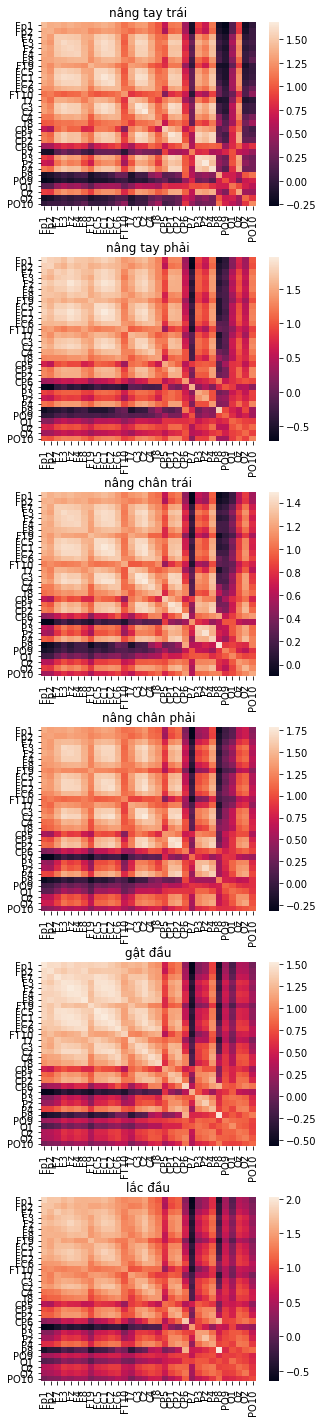

In [56]:
plt.rcParams["figure.figsize"] = (5,20)

fig, axes = plt.subplots(nrows=len(epochs), ncols=1)
fig.tight_layout(pad=3.0)

for i, (k, v) in enumerate(epochs.items()):
#     print(k)
    c = np.concatenate([covariance(vi.get_data()) for vi in v], axis=0).mean(axis=0)
    sb.heatmap(c, ax=axes[i], xticklabels=channels, yticklabels=channels)
    axes[i].set_title(k)

In [57]:
plt.rcParams["figure.figsize"] = (20,20)

nâng tay trái


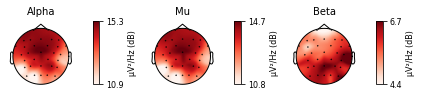

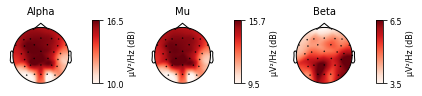

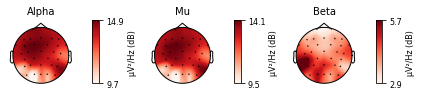

nâng tay phải


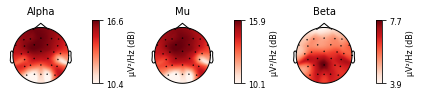

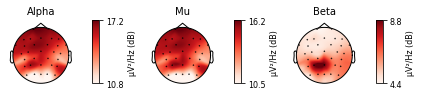

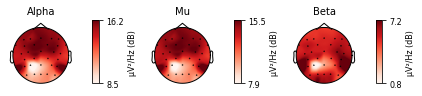

nâng chân trái


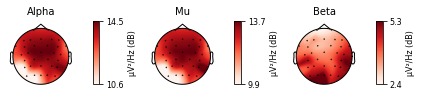

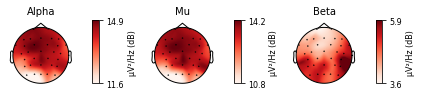

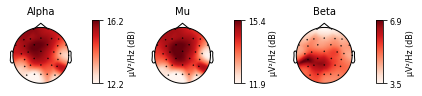

nâng chân phải


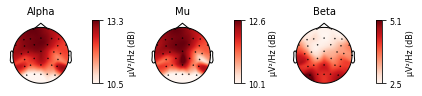

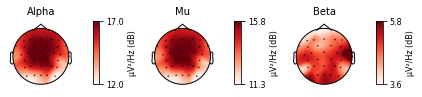

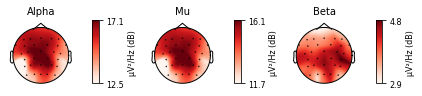

gật đầu


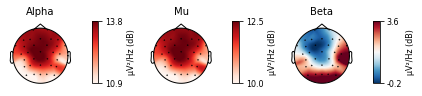

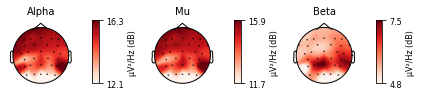

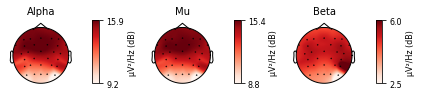

lắc đầu


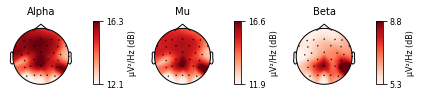

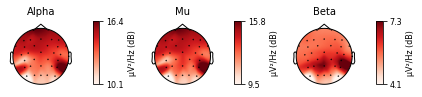

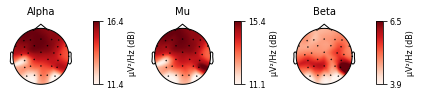

In [58]:
for k, v in epochs.items():
    print(k)
    for vi in v:
#         vi.plot_psd_topomap([(1, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (8, 14, 'Mu'), (12, 30, 'Beta'), (30, 45, 'Gamma')])
        vi.plot_psd_topomap([(8, 12, 'Alpha'), (8, 14, 'Mu'), (12, 30, 'Beta')])

nâng tay trái


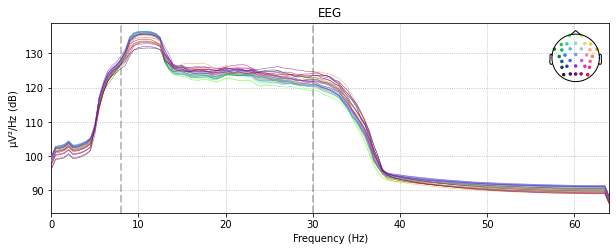

nâng tay phải


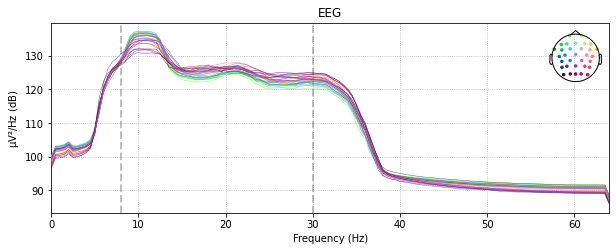

nâng chân trái


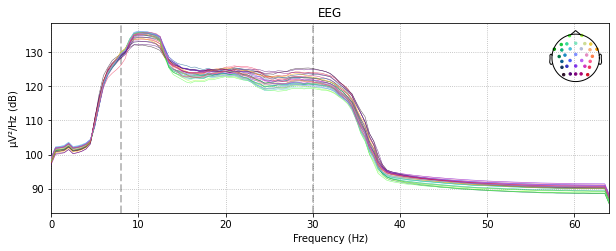

nâng chân phải


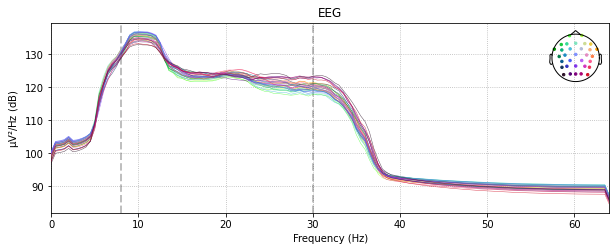

gật đầu


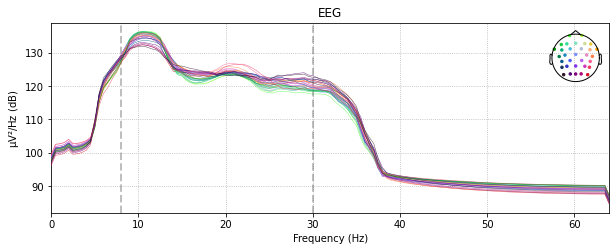

lắc đầu


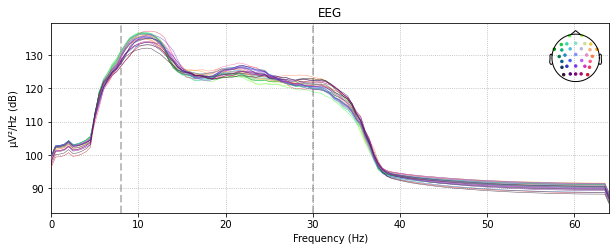

In [59]:
for k, v in epochs.items():
    print(k)
#     mne.concatenate_epochs(v).plot_psd(picks=[
#         "Fp1", "Fp2",
#         "F7", "F3", "Fz", "F4", "F8",
#         "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
#         "T7", "C3", "Cz", "C4", "T8",
#         "CP5", "CP1", "CP2", "CP6",
#         "P7", "P3", "Pz", "P4", "P8",
#         "PO9", "O1", "Oz", "O2", "PO10",
#     ])
    mne.concatenate_epochs(v).plot_psd()

In [5]:
ds_info[ds_info["subject"] == "K309"]

,subject,scenario,event,label,trial,split,epochs
0,K309,nâng tay trái,Thinking,mi,0,train,26
1,K309,nâng tay trái,Resting,other,0,train,22
2,K309,nâng tay trái,Resting,other,1,train,20
3,K309,nâng tay trái,Thinking,mi,1,train,22
4,K309,nâng tay trái,Resting,other,2,train,21
5,K309,nâng tay trái,Resting,other,3,train,18
6,K309,nâng tay trái,Thinking,mi,2,train,23
7,K309,nâng tay trái,Resting,other,4,train,23
8,K309,nâng tay trái,Resting,other,5,train,14
9,K309,nâng tay phải,Thinking,mi,0,train,24


In [51]:
ds.datasets[0].windows.event_id

{'other': 0,
 'gật đầu': 1,
 'lắc đầu': 2,
 'nâng chân phải': 3,
 'nâng chân trái': 4,
 'nâng tay phải': 5,
 'nâng tay trái': 6}

In [78]:
aligned_ds = deepcopy(ds)
euclidean_alignment(aligned_ds, target_subject=None, labeled_trials=None)

aligned_ds_info = aligned_ds.description

Xtrain = list()
Ytrain = list()
Xvalid = list()
Yvalid = list()

for i in aligned_ds_info[aligned_ds_info["subject"] == "K314"].index:
    Xtrain.append(aligned_ds.datasets[i].windows.get_data())
    Ytrain.extend(aligned_ds.datasets[i].y)
    
for i in aligned_ds_info[aligned_ds_info["subject"] == "K324"].index:
    Xvalid.append(aligned_ds.datasets[i].windows.get_data())
    Yvalid.extend(aligned_ds.datasets[i].y)
    
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xvalid = np.concatenate(Xvalid, axis=0)
Yvalid = np.array(Yvalid, dtype=int)

# Xtrain = np_standardize(Xtrain, tdim=2, robust=False)
# Xvalid = np_standardize(Xvalid, tdim=2, robust=False)

print(np.bincount(Ytrain), np.bincount(Yvalid))

# clf = make_pipeline(
#     Covariances("cov"),
#     TSclassifier(
#         metric="riemann",
#         # clf=SVC(
#         #     C=0.1,
#         #     kernel="rbf",
#         #     tol=1e-7,
#         #     max_iter=30000,
#         #     class_weight="balanced",
#         #     random_state=42,
#         # ),
#         clf=LinearDiscriminantAnalysis(
#             solver="lsqr",
#             shrinkage="auto",
#             n_components=None,
#             tol=1e-7,
#             covariance_estimator=None,
#         ),
#     ),
# )

# clf = make_pipeline(
#     Covariances("cov"),
#     FgMDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1),
#     # MDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1),
# )

clf = make_pipeline(
    FBCSP(
        filters=[(8, 12), (10, 14), (14, 18), (18, 22), (22, 26), (26, 30)],
        # filters=[(i, i + 2) for i in range(8, 30, 2)],
        filter_order=5,
        sfreq=128.0,
        n_components=8,
        # reg="ledoit_wolf",
        log=True,
        norm_trace=False,
    ),
    # SVC(
    #     C=1.0,
    #     kernel="rbf",
    #     tol=1e-7,
    #     max_iter=30000,
    #     class_weight="balanced",
    #     random_state=42,
    # ),
    LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto",
        n_components=None,
        tol=1e-7,
        covariance_estimator=None,
    ),
)

clf.fit(Xtrain, Ytrain)

y_pred = clf.predict(Xvalid)
print(metrics.classification_report(Yvalid, y_pred))
print(metrics.confusion_matrix(Yvalid, y_pred))
print(f"accuracy: {metrics.balanced_accuracy_score(Yvalid, y_pred)}")
print(f"f1_weighted: {metrics.f1_score(Yvalid, y_pred, average='weighted')}")

subject: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.77it/s]


[29 34] [32 31]
              precision    recall  f1-score   support

           0       1.00      0.16      0.27        32
           1       0.53      1.00      0.70        31

    accuracy                           0.57        63
   macro avg       0.77      0.58      0.48        63
weighted avg       0.77      0.57      0.48        63

[[ 5 27]
 [ 0 31]]
accuracy: 0.578125
f1_weighted: 0.48006594074009806


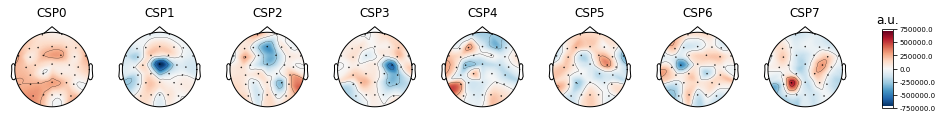

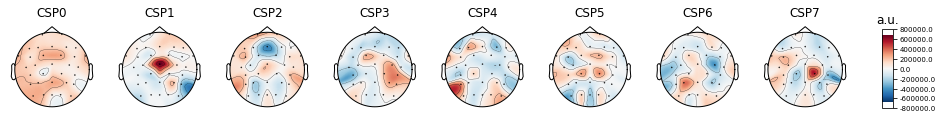

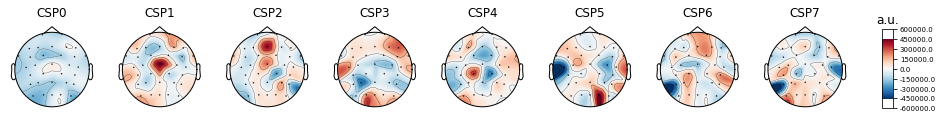

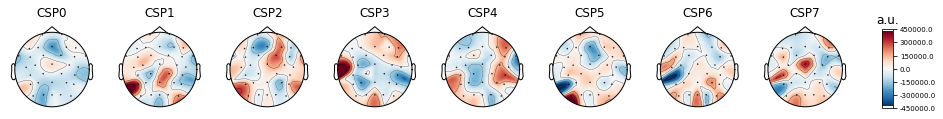

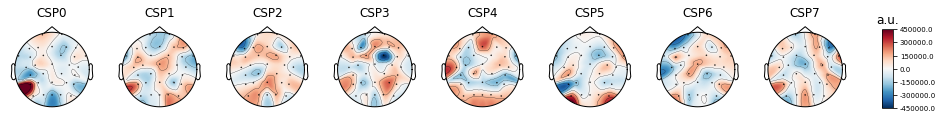

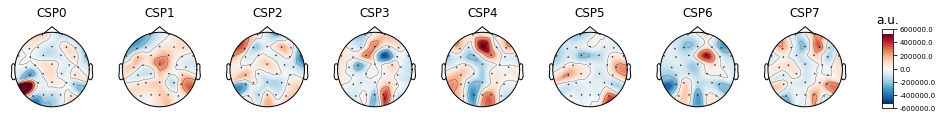

In [73]:
info = ds.datasets[0].windows.info

for csp in clf[0].filt_csp:
    csp.plot_patterns(info)

In [49]:
accs = list()
f1s = list()
# models = dict()
for subject in ds_info["subject"].unique():
# for subject in ["K309"]:
# for subject in ["BN001", "BN002", "BN003"]:
    acc = list()
    f1 = list()
    for train_idx in range(0, 3):
        print(f"subject {subject}/trial {train_idx}")
        
        try:
            labeled_trials = [train_idx]

            subject_ds = deepcopy(ds)
            # label_alignment(subject_ds, target_subject=subject, labeled_trials=labeled_trials)
            # euclidean_alignment(subject_ds, target_subject=subject, labeled_trials=None)

            Xtrain = list()
            Ytrain = list()
            Xvalid = list()
            Yvalid = list()
            # for i, r in ds_info.iterrows():
            #     if r["subject"] == subject and r["trial"] not in labeled_trials:
            #         Xvalid.append(subject_ds.datasets[i].windows.get_data())
            #         Yvalid.append(np.array(subject_ds.datasets[i].y, dtype=int))
            #     elif r["subject"] == subject or r["label"] != "other" or r["trial"] < 3:
            #         Xtrain.append(subject_ds.datasets[i].windows.get_data())
            #         Ytrain.append(np.array(subject_ds.datasets[i].y, dtype=int))

            for i, r in ds_info[ds_info["subject"] == subject].iterrows():
                if r["trial"] in labeled_trials:
#                 if r["scenario"] in ["nâng tay trái", "nâng chân trái", "gật đầu"]:
                    Xtrain.append(subject_ds.datasets[i].windows.get_data())
                    Ytrain.append(np.array(subject_ds.datasets[i].y, dtype=int))
                else:
                    Xvalid.append(subject_ds.datasets[i].windows.get_data())
                    Yvalid.append(np.array(subject_ds.datasets[i].y, dtype=int))

            # for i, r in ds_info.iterrows():
            #     if r["subject"] == subject:
            #         Xvalid.append(subject_ds.datasets[i].windows.get_data())
            #         Yvalid.append(np.array(subject_ds.datasets[i].y, dtype=int))
            #     else:
            #         Xtrain.append(subject_ds.datasets[i].windows.get_data())
            #         Ytrain.append(np.array(subject_ds.datasets[i].y, dtype=int))

            Xtrain = np.concatenate(Xtrain, axis=0)
            Ytrain = np.concatenate(Ytrain, axis=0)
            Xvalid = np.concatenate(Xvalid, axis=0)
            Yvalid = np.concatenate(Yvalid, axis=0)
            
            # Xtrain = standardize(Xtrain)
            # Xvalid = standardize(Xvalid)

#             print(f"train: {np.bincount(Ytrain)} - valid: {np.bincount(Yvalid)}")

    #         clf = make_pipeline(
    #             Covariances("cov"),
    #             #                     CSP(nfilter=16, metric="euclid", log=True),
    # #             mne.decoding.CSP(n_components=16, reg="ledoit_wolf", log=True),
    #             #             SVC(
    #             #                 C=1.0,
    #             #                 kernel="rbf",
    #             #                 tol=1e-7,
    #             #                 max_iter=30000,
    #             #                 class_weight="balanced",
    #             #                 random_state=42,
    #             #             ),
    # #             LinearDiscriminantAnalysis(
    # #                 solver="lsqr",
    # #                 shrinkage="auto",
    # #                 n_components=None,
    # #                 tol=1e-7,
    # #                 covariance_estimator=None,
    # #             ),
    #                             TSclassifier(
    #                                 metric="riemann",
    #                                 # clf=SVC(
    #                                 #     C=1.0,
    #                                 #     kernel="rbf",
    #                                 #     tol=1e-7,
    #                                 #     max_iter=30000,
    #                                 #     class_weight="balanced",
    #                                 #     random_state=42,
    #                                 # ),
    #             #                     clf=LogisticRegression(
    #             #                         C=1.0,
    #             #                         tol=1e-7,
    #             #                         class_weight="balanced",
    #             #                         random_state=42,
    #             #                         max_iter=30000,
    #             #                         n_jobs=-1,
    #             #                     ),
    #                                 clf=LinearDiscriminantAnalysis(
    #                                     solver="lsqr",
    #                                     shrinkage="auto",
    #                                     n_components=None,
    #                                     tol=1e-7,
    #                                     covariance_estimator=None,
    #                                 ),
    #                             ),
    #         )

#             clf = make_pipeline(
#                 Covariances("cov"),
#                 FgMDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1),
# #                 MDM(metric=dict(mean="riemann", distance="riemann"), n_jobs=-1),
#             )

            clf = make_pipeline(
                # FBCSP(
                #     filters=[(i, i + 4) for i in range(8, 28, 2)],
                #     filter_order=0,
                #     sfreq=128.0,
                #     n_components=8,
                #     # reg="ledoit_wolf",
                #     log=True,
                #     norm_trace=False,
                # ),
                mne.decoding.CSP(
                    n_components=8,
                    # reg="ledoit_wolf",
                    log=True,
                    norm_trace=False,
                ), 
                # SVC(
                #     C=1.0,
                #     kernel="rbf",
                #     tol=1e-7,
                #     max_iter=30000,
                #     class_weight="balanced",
                #     random_state=42,
                # ),
                LinearDiscriminantAnalysis(
                    solver="lsqr",
                    shrinkage="auto",
                    n_components=None,
                    tol=1e-7,
                    covariance_estimator=None,
                ),
            )
                                    
#             clf = make_pipeline(
#                 FBCSP(
#                     filters=[(8, 12), (10, 14), (14, 18), (18, 22), (22, 26), (26, 30)],
#                     filter_order=5,
#                     sfreq=128.0,
#                     n_components=8,
# #                     reg="ledoit_wolf",
#                     log=True,
#                     norm_trace=False,
#                 ),
# #                 SVC(
# #                     C=1.0,
# #                     kernel="rbf",
# #                     tol=1e-7,
# #                     max_iter=30000,
# #                     class_weight="balanced",
# #                     random_state=42,
# #                 ),
#                 LinearDiscriminantAnalysis(
#                     solver="lsqr",
#                     shrinkage="auto",
#                     n_components=None,
#                     tol=1e-7,
#                     covariance_estimator=None,
#                 ),
#             )

            # bandpower
            #         bp = yasa.bandpower(x[0], sf=128, ch_names=ch_names, win_sec=2, relative=True, bandpass=True, bands=[(4, 8, 'Theta'), (8, 13, 'Alpha'), (13, 30, 'Beta')])
            #         bp = np.asarray(bp[["Theta", "Alpha", "Beta"]], dtype=np.float32).flatten()
            #         bp

            #         ch_names = subject_ds.datasets[0].windows.info["ch_names"]

            #         X = list()
            #         for i in range(len(Xtrain)):
            #             bp = yasa.bandpower(Xtrain[i], sf=128, ch_names=ch_names, win_sec=2, relative=True, bandpass=True, bands=[(4, 7, 'Theta'), (8, 12, 'Alpha'), (8, 13, 'Mu'), (12.5, 15.5, 'SMR'), (16, 30, 'Beta')])
            #             bp = bp[["Theta", "Alpha", "Mu", "SMR", "Beta"]]
            #             X.append(np.asarray(bp, dtype=np.float32).flatten())

            #         Xtrain = np.stack(X)

            #         X = list()
            #         for i in range(len(Xvalid)):
            #             bp = yasa.bandpower(Xvalid[i], sf=128, ch_names=ch_names, win_sec=2, relative=True, bandpass=True, bands=[(4, 7, 'Theta'), (8, 12, 'Alpha'), (8, 13, 'Mu'), (12.5, 15.5, 'SMR'), (16, 30, 'Beta')])
            #             bp = bp[["Theta", "Alpha", "Mu", "SMR", "Beta"]]
            #             X.append(np.asarray(bp, dtype=np.float32).flatten())

            #         Xvalid = np.stack(X)

            #         clf = LinearSVC(
            #                 C=1.0,
            # #                 kernel="rbf",
            #                 tol=1e-7,
            #                 max_iter=30000,
            #                 class_weight="balanced",
            #                 random_state=42,
            #             )

            # training
            clf.fit(Xtrain, Ytrain)

            # models[f"{subject}_{train_idx}"] = clf

            # predict
            y_pred = clf.predict(Xvalid)
            # print(f"subject {subject}")
            # print(metrics.classification_report(Yvalid, y_pred))
#             print(metrics.confusion_matrix(Yvalid, y_pred))
            print(f"accuracy: {metrics.balanced_accuracy_score(Yvalid, y_pred)}")
            print(f"f1_weighted: {metrics.f1_score(Yvalid, y_pred, average='weighted')}")
            # break

            acc.append(metrics.balanced_accuracy_score(Yvalid, y_pred))
            f1.append(metrics.f1_score(Yvalid, y_pred, average="weighted"))

        except Exception as e:
            print(f"subject {subject} failed - {e}")

            acc.append(None)
            f1.append(None)
            
    accs.append(acc)
    f1s.append(f1)

subject K299/trial 0
accuracy: 0.31510478685401283
f1_weighted: 0.32272106808680734
subject K299/trial 1
accuracy: 0.40991467229552486
f1_weighted: 0.39848216917182433
subject K299/trial 2
accuracy: 0.3269069030212849
f1_weighted: 0.26624165715668985
subject K300/trial 0
accuracy: 0.6043714168714169
f1_weighted: 0.6110461810971314
subject K300/trial 1
accuracy: 0.4664608928967702
f1_weighted: 0.444722593339656
subject K300/trial 2
accuracy: 0.42106307435254803
f1_weighted: 0.4290978316569665
subject K309/trial 0
accuracy: 0.567160690187006
f1_weighted: 0.5706955924297054
subject K309/trial 1
accuracy: 0.7801282051282051
f1_weighted: 0.7737018240288589
subject K309/trial 2
accuracy: 0.5767211370548982
f1_weighted: 0.5661609992702236
subject K310/trial 0
accuracy: 0.34776422764227644
f1_weighted: 0.31864835497820143
subject K310/trial 1
accuracy: 0.23771664460830655
f1_weighted: 0.21070999572337665
subject K310/trial 2
accuracy: 0.33756868131868134
f1_weighted: 0.3087476595950621
subject

/home/administrator/.local/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/administrator/.local/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


subject K318 failed - SVD did not converge
subject K318/trial 1
accuracy: 0.26293747664715406
f1_weighted: 0.20618824954949355
subject K318/trial 2


/home/administrator/.local/lib/python3.8/site-packages/mne/decoding/csp.py:638: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(omega12 * omega21)
/home/administrator/.local/lib/python3.8/site-packages/mne/decoding/csp.py:640: RuntimeWarning: invalid value encountered in sqrt
  tmp = np.sqrt(omega21 / omega12)


subject K318 failed - SVD did not converge
subject K319/trial 0
accuracy: 0.1511904761904762
f1_weighted: 0.10802990113334941
subject K319/trial 1
accuracy: 0.27548734294161126
f1_weighted: 0.26382373845060414
subject K319/trial 2
accuracy: 0.35570216618603717
f1_weighted: 0.29488867317261835
subject K320/trial 0
accuracy: 0.8205128205128205
f1_weighted: 0.7675151515151516
subject K320/trial 1
accuracy: 0.5707070707070707
f1_weighted: 0.49868868382710047
subject K320/trial 2
accuracy: 0.9184060721062619
f1_weighted: 0.9140878856494409
subject K321/trial 0
accuracy: 0.7742914979757085
f1_weighted: 0.7540689190706027
subject K321/trial 1
accuracy: 0.5530405405405405
f1_weighted: 0.5384310218410567
subject K321/trial 2
accuracy: 0.7596086940599136
f1_weighted: 0.7471820575757451
subject K322/trial 0
accuracy: 0.6953823953823954
f1_weighted: 0.6927837373923106
subject K322/trial 1
accuracy: 0.6204670040059035
f1_weighted: 0.6153523137650122
subject K322/trial 2
accuracy: 0.7914363226863227

In [59]:
f11, f12, f13 = zip(*f1s)
a11, a12, a13 = zip(*accs)

result = pd.DataFrame(
    {
        "subject": ds_info["subject"].unique(),
        "a11": a11,
        "a12": a12,
        "a13": a13,
        "f11": f11,
        "f12": f12,
        "f13": f13,
    }
)

result["acc"] = (result["a11"] + result["a12"] + result["a13"]) / 3
result["f1"] = (result["f11"] + result["f12"] + result["f13"]) / 3

# result.to_csv("../data/vin/Results/cov_ts_lda_8_30_32_2_02.csv", sep="\t", index=False)

result.loc[7, "subject"] = "K314"
result.loc[16, "subject"] = "K324"

result = result.sort_values("acc", ascending=False).reset_index(drop=True)
print(sorted(list(result["subject"][:40])))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(result)

# result.sort_values("acc", ascending=False)[:50].reset_index(drop=True)
# print(sorted(result.sort_values("acc", ascending=False)[:35]["subject"].unique()))

['K300', 'K309', 'K311', 'K312', 'K313', 'K314', 'K315', 'K316', 'K320', 'K321', 'K322', 'K324', 'K325', 'K326', 'K327', 'K328', 'K329', 'K331', 'K332', 'K335', 'K336', 'K337', 'K338', 'K339', 'K340', 'K354', 'K355', 'K357', 'K358', 'K359', 'K361', 'K362', 'K366', 'K367', 'K368', 'K369', 'K370', 'K371', 'K374', 'K375']
   subject       a11       a12       a13       f11       f12       f13  \
0     K370  0.879073  0.934783  0.940678  0.874467  0.928016  0.939363   
1     K328  0.988630  0.813787  0.889189  0.988336  0.827703  0.890909   
2     K313  0.790291  0.809635  0.796816  0.778462  0.804232  0.793231   
3     K311  0.832803  0.768687  0.730903  0.848292  0.784992  0.722132   
4     K320  0.820513  0.570707  0.918406  0.767515  0.498689  0.914088   
5     K312  0.762674  0.699068  0.835775  0.796677  0.715978  0.830742   
6     K366  0.696154  0.814829  0.654835  0.668007  0.824686  0.651094   
7     K324  0.683454  0.634414  0.795058  0.668098  0.594467  0.779123   
8     K322  0

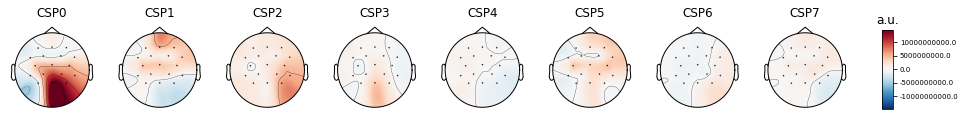

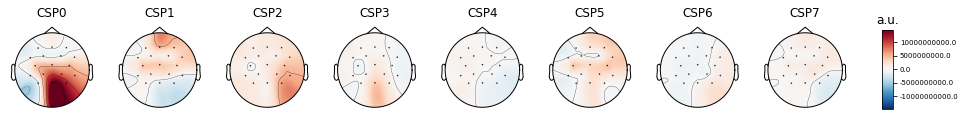

In [24]:
models["K309_1"][0].filt_csp[0].plot_patterns(info=ds.datasets[0].windows.info)

In [44]:
f11, f12, f13 = zip(*f1s)
a11, a12, a13 = zip(*accs)

result = pd.DataFrame(
    {
        "subject": ds_info["subject"].unique(),
        "a11": a11,
        "a12": a12,
        "a13": a13,
        "f11": f11,
        "f12": f12,
        "f13": f13,
    }
)

result["acc"] = (result["a11"] + result["a12"] + result["a13"]) / 3
result["f1"] = (result["f11"] + result["f12"] + result["f13"]) / 3

# result.to_csv("../data/vin/Results/cov_ts_lda_8_30_32_2_02.csv", sep="\t", index=False)

result.loc[5, "subject"] = "K314"
result.loc[12, "subject"] = "K324"

result

# result.sort_values("acc", ascending=False)[:50].reset_index(drop=True)
# print(sorted(result.sort_values("acc", ascending=False)[:35]["subject"].unique()))

,subject,a11,a12,a13,f11,f12,f13,acc,f1
0,K300,0.766673,0.672004,0.693246,0.697823,0.649499,0.731489,0.710641,0.692937
1,K309,0.941595,0.978632,0.977102,0.941511,0.977520,0.977934,0.965777,0.965655
2,K311,0.806000,0.772007,0.788804,0.800426,0.792475,0.791909,0.788937,0.794936
3,K312,0.687781,0.738432,0.802744,0.650780,0.731010,0.774972,0.742986,0.718921
4,K313,0.864640,0.877386,0.806731,0.873869,0.866326,0.787891,0.849586,0.842695
5,K314,0.576377,0.709565,0.614881,0.489834,0.668734,0.552903,0.633607,0.570491
6,K315,0.806840,0.769657,0.864649,0.798550,0.769862,0.864856,0.813716,0.811090
7,K316,0.690961,0.778419,0.739696,0.650326,0.742461,0.707266,0.736359,0.700018
8,K320,0.694444,0.761409,0.879484,0.633672,0.713881,0.881367,0.778446,0.742973
9,K321,0.765097,0.895595,0.861453,0.737419,0.893363,0.860994,0.840715,0.830592


<AxesSubplot:xlabel='subject'>

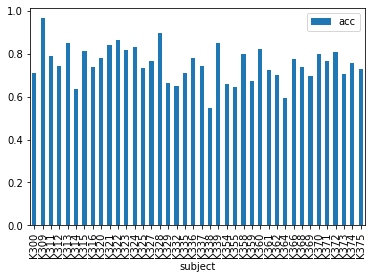

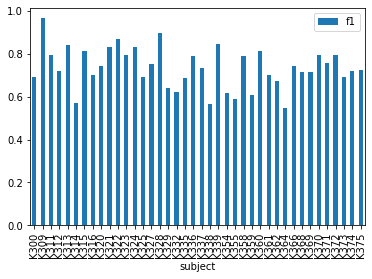

In [46]:
result.plot.bar(x="subject", y="acc")
result.plot.bar(x="subject", y="f1")

In [12]:
f11, f12, f13 = zip(*f1s)
a11, a12, a13 = zip(*accs)

result = pd.DataFrame(
    {
        "subject": ds_info["subject"].unique(),
        "a11": a11,
        "a12": a12,
        "a13": a13,
        "f11": f11,
        "f12": f12,
        "f13": f13,
    }
)

result["acc"] = (result["a11"] + result["a12"] + result["a13"]) / 3
result["f1"] = (result["f11"] + result["f12"] + result["f13"]) / 3

# result.to_csv("/tmp/t21.csv", sep="\t", index=False)

print(sorted(result.sort_values("acc", ascending=False)[:12]["subject"].unique()))

['K309', 'K311', 'K313', 'K315', 'K323', 'K324', 'K335', 'K337', 'K339', 'K360', 'K366', 'K372']


[0 1 2 3 4 5 6]


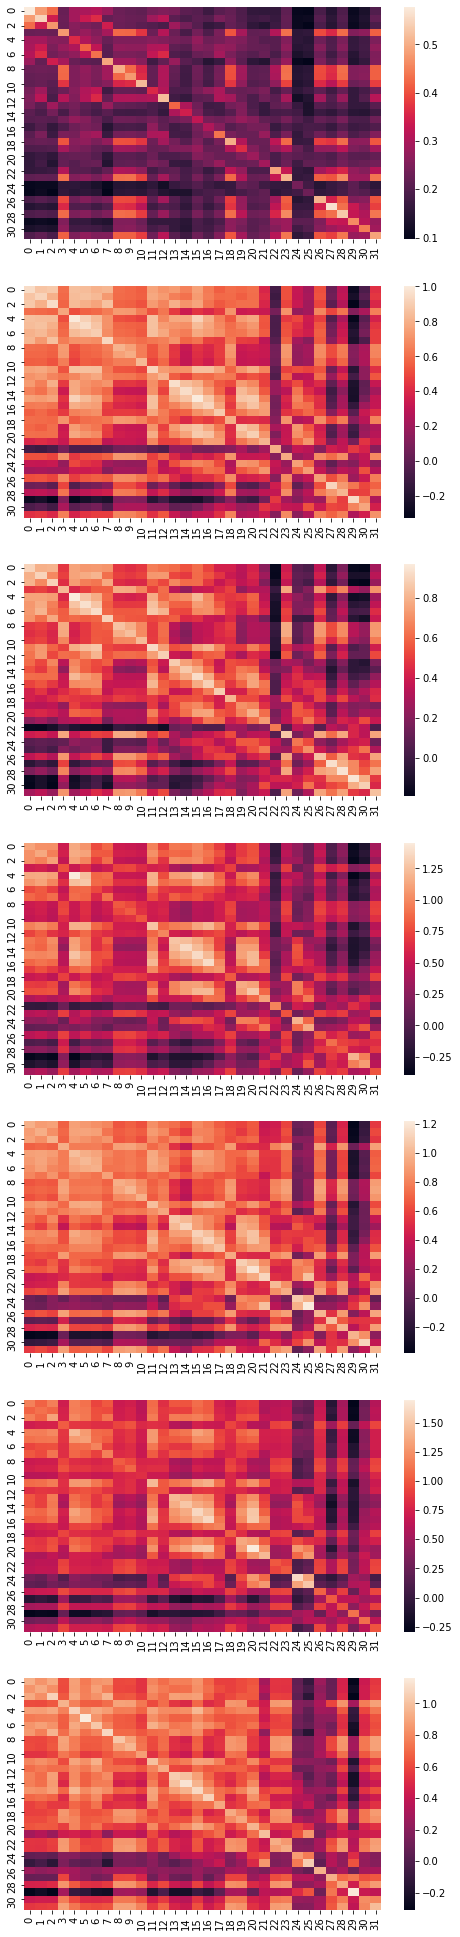

In [50]:
plt.rcParams["figure.figsize"] = (8,35)

fig, axes = plt.subplots(nrows=7, ncols=1)

print(models["K309_0"][1].classes_)

for i, c in enumerate(models["K309_0"][1].covmeans_):
    sb.heatmap(c, ax=axes[i])

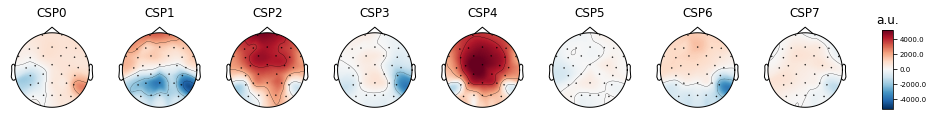

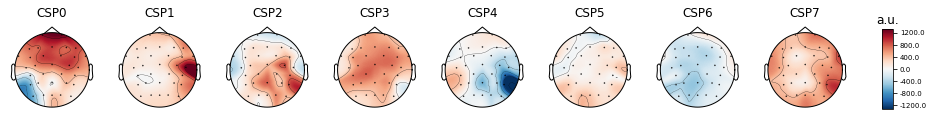

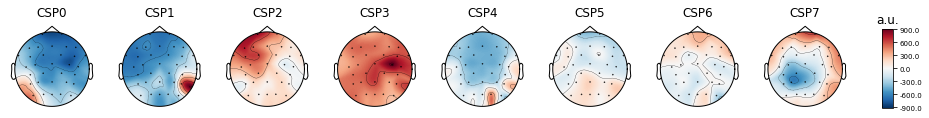

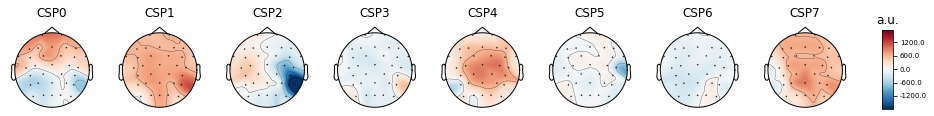

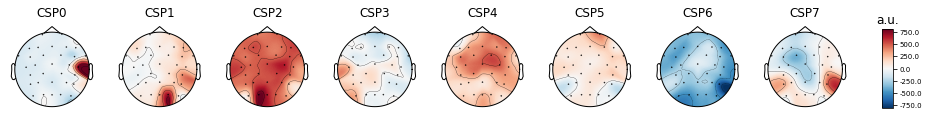

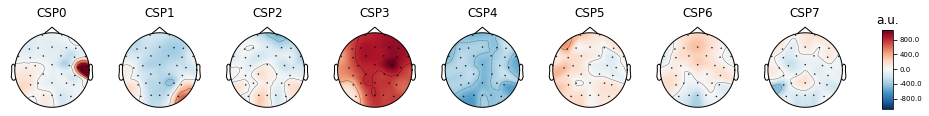

In [18]:
info = ds.datasets[ds_info[ds_info["subject"] == "K322"].index[0]].windows.info

for csp in models["K322_0"][0].filt_csp:
    csp.plot_patterns(info)

In [44]:
from mne.time_frequency import tfr_multitaper

In [46]:
subject_ds_info = ds_info[ds_info["subject"] == "K322"]
subject_ds_info

,subject,scenario,event,label,trial,split
145,K322,nâng tay trái,Thinking,nâng tay trái,0,train
146,K322,nâng tay trái,Thinking,nâng tay trái,1,train
147,K322,nâng tay trái,Thinking,nâng tay trái,2,train
148,K322,nâng tay phải,Thinking,nâng tay phải,0,train
149,K322,nâng tay phải,Thinking,nâng tay phải,1,train
150,K322,nâng tay phải,Thinking,nâng tay phải,2,train
151,K322,nâng chân trái,Thinking,nâng chân trái,0,train
152,K322,nâng chân trái,Thinking,nâng chân trái,1,train
153,K322,nâng chân trái,Thinking,nâng chân trái,2,train
154,K322,nâng chân phải,Thinking,nâng chân phải,0,train


In [47]:
freq_range = np.arange(8, 33)

sample_epochs = ds.datasets[subject_ds_info[subject_ds_info["label"] == "nâng tay trái"].index[0]].windows

tfr = tfr_multitaper(sample_epochs, freqs=freq_range, n_cycles=freq_range, use_fft=True,
                     return_itc=False, average=True, decim=2)

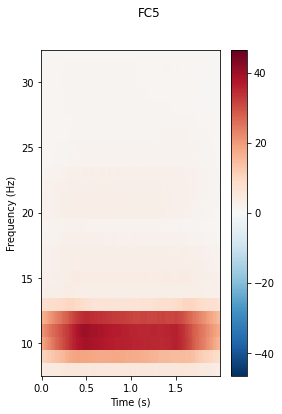

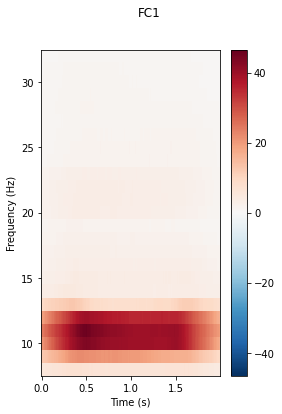

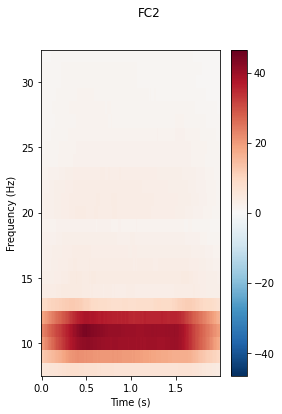

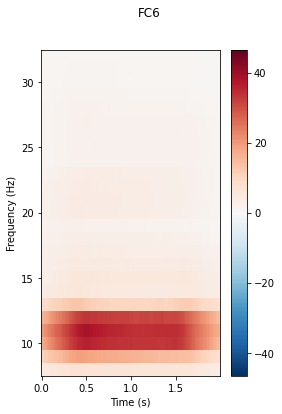

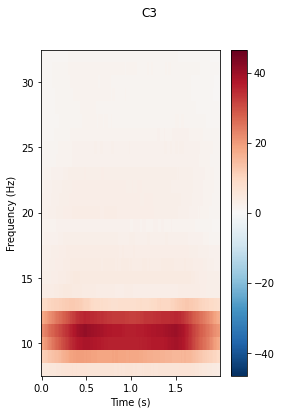

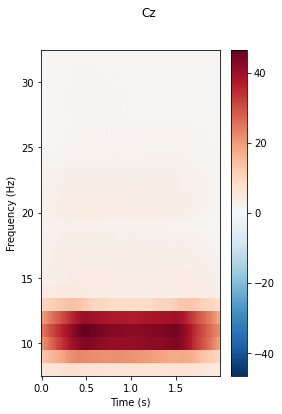

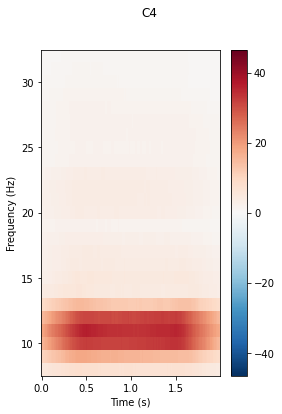

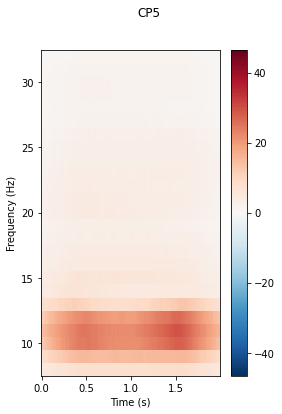

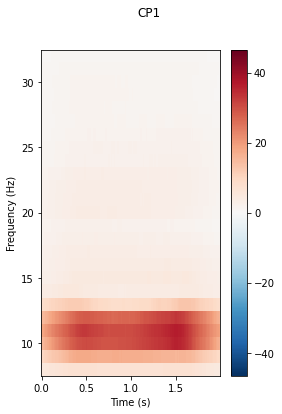

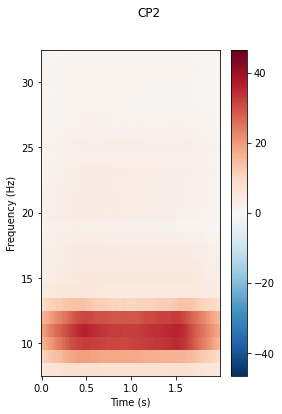

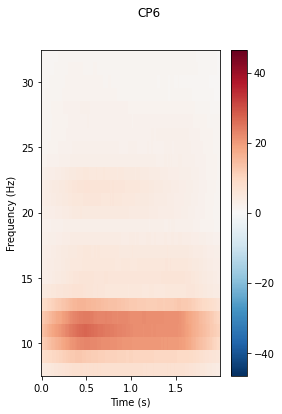

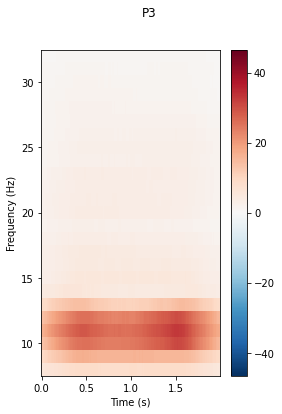

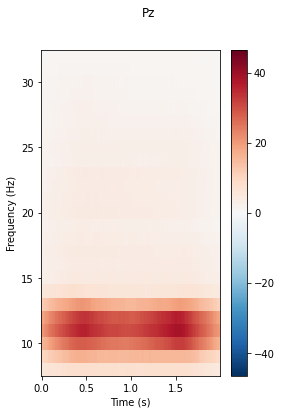

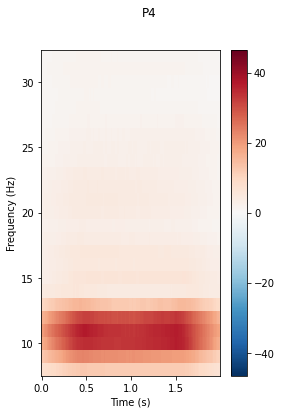

[<Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>,
 <Figure size 288x432 with 2 Axes>]

In [48]:
plt.rcParams["figure.figsize"] = (4,6)

tfr.plot(title="auto")

In [41]:
f11, f12, f13 = zip(*f1s)
a11, a12, a13 = zip(*accs)

result = pd.DataFrame(
    {
        "subject": ds_info["subject"].unique()[:34],
        "a11": a11,
        "a12": a12,
        "a13": a13,
        "f11": f11,
        "f12": f12,
        "f13": f13,
    }
)

result["acc"] = (result["a11"] + result["a12"] + result["a13"]) / 3
result["f1"] = (result["f11"] + result["f12"] + result["f13"]) / 3

result.sort_values("acc", ascending=False).reset_index(drop=True)

,subject,a11,a12,a13,f11,f12,f13,acc,f1
0,K322,0.827786,0.821586,0.856727,0.831471,0.812772,0.846536,0.835366,0.830260
1,K309,0.757859,0.910278,0.759668,0.762674,0.907252,0.749628,0.809268,0.806518
2,K323,0.805580,0.788600,0.738743,0.755559,0.767110,0.728283,0.777641,0.750317
3,K324,0.789830,0.717453,0.821776,0.790487,0.695852,0.809402,0.776353,0.765247
4,K361,0.776666,0.788800,0.698372,0.779278,0.787195,0.657197,0.754613,0.741224
5,K339,0.725916,0.744594,0.772112,0.748800,0.728322,0.780599,0.747541,0.752574
6,K328,0.777317,0.747532,0.680822,0.732466,0.718897,0.650358,0.735223,0.700574
7,K321,0.686922,0.686228,0.752978,0.612185,0.645180,0.736801,0.708710,0.664722
8,K330,0.640458,0.880493,0.603426,0.637527,0.881453,0.557069,0.708125,0.692017
9,K370,0.601732,0.752428,0.708143,0.578966,0.741310,0.683306,0.687434,0.667861


In [31]:
f11, f12, f13 = zip(*f1s)
a11, a12, a13 = zip(*accs)

result = pd.DataFrame(
    {
        "subject": ds_info["subject"].unique(),
        "a11": a11,
        "a12": a12,
        "a13": a13,
        "f11": f11,
        "f12": f12,
        "f13": f13,
    }
)

result["acc"] = (result["a11"] + result["a12"] + result["a13"]) / 3
result["f1"] = (result["f11"] + result["f12"] + result["f13"]) / 3

result.sort_values("acc", ascending=False).reset_index(drop=True)

,subject,a11,a12,a13,f11,f12,f13,acc,f1
0,K322,0.833333,0.868421,0.865546,0.785437,0.872910,0.874348,0.855767,0.844232
1,K309,0.803188,0.916667,0.844203,0.804877,0.909541,0.841283,0.854686,0.851900
2,K313,0.744906,0.890227,0.762399,0.728638,0.876744,0.743346,0.799177,0.782909
3,K328,0.821279,0.844209,0.730100,0.827434,0.846112,0.695604,0.798529,0.789717
4,K324,0.758859,0.860269,0.757962,0.759006,0.861831,0.760002,0.792363,0.793613
5,K370,0.589143,0.818884,0.873075,0.526797,0.817256,0.879481,0.760368,0.741178
6,K323,0.747222,0.714286,0.780686,0.680571,0.678627,0.741505,0.747398,0.700234
7,K372,0.709280,0.769908,0.694121,0.682097,0.759193,0.672133,0.724436,0.704474
8,K360,0.645473,0.832913,0.691932,0.611402,0.815378,0.664520,0.723439,0.697100
9,K311,0.773357,0.707961,0.678893,0.746957,0.732720,0.665186,0.720070,0.714954


In [16]:
print(sorted(result.sort_values("acc", ascending=False)[:35]["subject"].unique()))

['K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K320', 'K321', 'K322', 'K323', 'K324', 'K325', 'K326', 'K327', 'K328', 'K329', 'K330', 'K337', 'K339', 'K354', 'K358', 'K359', 'K360', 'K361', 'K362', 'K365', 'K366', 'K367', 'K368', 'K369', 'K370', 'K371', 'K372', 'K374', 'K375']


In [22]:
s1 = set(['K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K320', 'K321', 'K322', 'K323', 'K324', 'K325', 'K326', 'K327', 'K328', 'K329', 'K330', 'K337', 'K339', 'K354', 'K358', 'K359', 'K360', 'K361', 'K362', 'K365', 'K366', 'K367', 'K368', 'K369', 'K370', 'K371', 'K372', 'K374', 'K375'])

In [21]:
print(sorted(result.sort_values("acc", ascending=False)[:35]["subject"].unique()))

['K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K320', 'K321', 'K322', 'K323', 'K324', 'K325', 'K326', 'K327', 'K328', 'K329', 'K330', 'K337', 'K339', 'K354', 'K355', 'K358', 'K359', 'K360', 'K361', 'K362', 'K365', 'K366', 'K368', 'K369', 'K370', 'K371', 'K372', 'K374', 'K375']


In [23]:
s2 = set(['K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K320', 'K321', 'K322', 'K323', 'K324', 'K325', 'K326', 'K327', 'K328', 'K329', 'K330', 'K337', 'K339', 'K354', 'K355', 'K358', 'K359', 'K360', 'K361', 'K362', 'K365', 'K366', 'K368', 'K369', 'K370', 'K371', 'K372', 'K374', 'K375'])

In [26]:
print(s1 - s2)
print(s2 - s1)

{'K367'}
{'K355'}


In [27]:
print(sorted(result.sort_values("acc", ascending=False)[:35]["subject"].unique()))

['K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K320', 'K321', 'K322', 'K323', 'K324', 'K325', 'K326', 'K327', 'K328', 'K329', 'K330', 'K337', 'K339', 'K354', 'K355', 'K358', 'K359', 'K360', 'K361', 'K362', 'K365', 'K366', 'K368', 'K369', 'K370', 'K371', 'K372', 'K374', 'K375']


In [88]:
result = pd.DataFrame(
    {
        "subject": ds_info["subject"].unique(),
        #         "subject": ["BN001", "BN002", "BN003"],
        "balanced_accuracy": acc,
        "f1_weighted": f1,
    }
)

print(f"mean acc: {np.mean(result['balanced_accuracy'])}")
print(f"mean f1: {np.mean(result['f1_weighted'])}")

# result.to_csv("../data/vin/Results/lwf_ts_rbf_svm_head.csv", sep="\t", index=False)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(result.sort_values("balanced_accuracy", ascending=False))
    # print(result)

# print(sorted(result.sort_values("f1_weighted", ascending=False)[:30]["subject"].unique()))

mean acc: 0.7040474520701131
mean f1: 0.7349637272919944
   subject  balanced_accuracy  f1_weighted
27    K337           1.000000     1.000000
11    K321           1.000000     1.000000
22    K332           0.955882     0.955796
15    K325           0.950000     0.950660
43    K359           0.932407     0.957358
53    K369           0.928571     0.949368
4     K313           0.925444     0.908386
2     K311           0.917087     0.936600
12    K322           0.900000     0.872881
46    K362           0.886252     0.927655
0     K309           0.875371     0.915010
18    K328           0.873333     0.933825
16    K326           0.838505     0.855332
10    K320           0.831687     0.797980
56    K372           0.825758     0.834031
45    K361           0.822543     0.850979
6     K315           0.808642     0.897056
57    K373           0.805556     0.836814
26    K336           0.802221     0.723876
35    K351           0.800000     0.772222
17    K327           0.800000     0.7870

In [9]:
ds_info[ds_info["subject"] == "K309"]

,subject,scenario,event,label,trial,split
0,K309,nâng tay trái,Thinking,nâng tay trái,0,train
1,K309,nâng tay trái,Thinking,nâng tay trái,1,train
2,K309,nâng tay trái,Thinking,nâng tay trái,2,train
3,K309,nâng tay phải,Thinking,nâng tay phải,0,train
4,K309,nâng tay phải,Thinking,nâng tay phải,1,train
5,K309,nâng tay phải,Thinking,nâng tay phải,2,train
6,K309,nâng chân trái,Thinking,nâng chân trái,0,train
7,K309,nâng chân trái,Thinking,nâng chân trái,1,train
8,K309,nâng chân trái,Thinking,nâng chân trái,2,train
9,K309,nâng chân phải,Thinking,nâng chân phải,0,train


In [61]:
subject_ds_index = ds_info[(ds_info["subject"] == "K309")].index

idx = list()
x = list()
y_true = list()
for i in subject_ds_index:
    xi = ds.datasets[i].windows.get_data()
    idx.extend([i] * len(xi))
    x.append(xi)
    y_true.append(np.array(ds.datasets[i].y, dtype=int))
    
idx = np.array(idx, dtype=int)
x = np.concatenate(x, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_pred = models["K309"].predict(x)

# print(idx)
print(x.shape)
# print(y_true)
# print(y_pred)

(428, 32, 256)


In [70]:
proba = np.round(models["K309"].predict_proba(x), 3)

In [62]:
ds.datasets[subject_ds_index[0]].windows.event_id

{'gật đầu': 0,
 'lắc đầu': 1,
 'nâng chân phải': 2,
 'nâng chân trái': 3,
 'nâng tay phải': 4,
 'nâng tay trái': 5}

In [63]:
c = models["K309"][0].transform(x)

In [73]:
yi = np.where((y_pred == 0) & (y_true != 0))[0]
print(proba[yi])

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


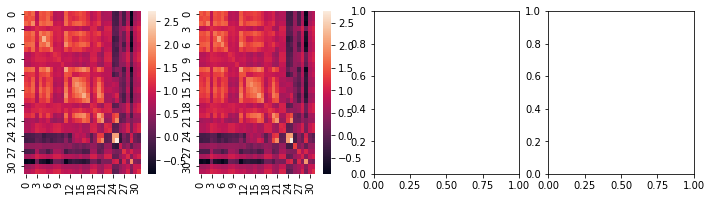

In [75]:
plt.rcParams["figure.figsize"] = (12, (len(yi) // 4 + 1) * 3)

fig, axes = plt.subplots(nrows=len(yi) // 4 + 1, ncols=4)

for i in range(len(yi)):
    sb.heatmap(c[i], ax=axes[i % 4])

In [ ]:
# mean acc: 0.5285254117454274
# mean f1: 0.6801943366422962
#    subject  balanced_accuracy  f1_weighted
# 0     K309           0.615661     0.851254
# 1     K311           0.704672     0.866309
# 2     K312           0.325698     0.634502
# 3     K313           0.579192     0.781796
# 4     K315           0.456927     0.737132
# 5     K316           0.576462     0.796409
# 6     K321           0.462794     0.379636
# 7     K322           0.732288     0.758003
# 8     K323           0.611831     0.740875
# 9     K324           0.612659     0.612384
# 10    K325           0.611386     0.533514
# 11    K326           0.413018     0.408232
# 12    K328           0.369176     0.621873
# 13    K329           0.311557     0.303740
# 14    K337           0.542006     0.628796
# 15    K338           0.422360     0.774392
# 16    K339           0.633951     0.862735
# 17    K358           0.692348     0.854620
# 18    K359           0.535267     0.791922
# 19    K360           0.535662     0.717782
# 20    K361           0.548644     0.724081
# 21    K365           0.545500     0.494837
# 22    K366           0.662136     0.857036
# 23    K367           0.448544     0.481025
# 24    K368           0.467168     0.688437
# 25    K369           0.535430     0.795100
# 26    K370           0.502765     0.766785
# 27    K371           0.394807     0.608285
# 28    K372           0.624438     0.806023
# 29    K375           0.381415     0.528317

In [ ]:
# rest, dau, tay, chan
# mean acc: 0.7748150878178441
# mean f1: 0.8352212231427364
#    subject  balanced_accuracy  f1_weighted
# 0     K300           0.733364     0.847350
# 1     K309           0.792202     0.898212
# 2     K311           0.966470     0.951331
# 3     K312           0.619635     0.780814
# 4     K313           0.841384     0.883841
# 5     K315           0.701735     0.839096
# 6     K316           0.864529     0.833082
# 7     K321           0.841069     0.848139
# 8     K322           0.789987     0.825554
# 9     K323           0.818286     0.883683
# 10    K324           0.767493     0.795657
# 11    K326           0.687646     0.746004
# 12    K328           0.692416     0.808001
# 13    K329           0.603628     0.677356
# 14    K337           0.764453     0.836127
# 15    K338           0.784556     0.868847
# 16    K339           0.753518     0.872362
# 17    K343           0.776375     0.887311
# 18    K355           0.742298     0.874354
# 19    K358           0.838606     0.827203
# 20    K359           0.834414     0.923315
# 21    K360           0.808643     0.809510
# 22    K361           0.797299     0.778722
# 23    K365           0.815705     0.814443
# 24    K368           0.721476     0.793609
# 25    K369           0.794809     0.829304
# 26    K370           0.828427     0.855234
# 27    K371           0.656833     0.735440
# 28    K372           0.933026     0.938543
# 29    K375           0.674172     0.794189

In [ ]:
# chan , tay trai , tay phai
# mean acc: 0.7322310767093025
# mean f1: 0.7684022501031712
#    subject  balanced_accuracy  f1_weighted
# 0     K300           0.613821     0.665029
# 1     K309           0.978723     0.983195
# 2     K311           0.886325     0.911885
# 3     K312           0.820616     0.860264
# 4     K313           0.748634     0.759162
# 5     K315           0.654739     0.723700
# 6     K316           0.624434     0.700075
# 7     K321           0.977778     0.983454
# 8     K322           0.852713     0.879424
# 9     K323           0.501011     0.532566
# 10    K324           0.791429     0.829251
# 11    K326           0.537047     0.575372
# 12    K328           0.846266     0.868980
# 13    K329           0.883625     0.879017
# 14    K337           0.864198     0.890375
# 15    K338           0.699499     0.785011
# 16    K339           0.722705     0.738868
# 17    K343           0.350877     0.370119
# 18    K355           0.648618     0.711578
# 19    K358           0.757576     0.782744
# 20    K359           0.720725     0.754935
# 21    K360           0.670597     0.693146
# 22    K361           0.666667     0.749476
# 23    K365           0.591754     0.646679
# 24    K368           0.596376     0.663469
# 25    K369           0.754110     0.794906
# 26    K370           0.876812     0.910869
# 27    K371           0.741497     0.791321
# 28    K372           0.884058     0.912798
# 29    K375           0.703704     0.704397

In [ ]:
# mean acc: 0.7146747909227289
# mean f1: 0.7515294786310471
#    subject  balanced_accuracy  f1_weighted
# 0     K300           0.623533     0.675993
# 1     K309           0.974359     0.979526
# 2     K311           0.918998     0.937338
# 3     K312           0.625026     0.651825
# 4     K313           0.748428     0.757274
# 5     K315           0.640000     0.707630
# 6     K316           0.612491     0.690970
# 7     K321           1.000000     1.000000
# 8     K322           0.838095     0.865756
# 9     K323           0.482456     0.511214
# 10    K324           0.776856     0.810297
# 11    K326           0.447524     0.497296
# 12    K328           0.840176     0.859321
# 13    K329           0.849779     0.862332
# 14    K337           0.847826     0.875571
# 15    K338           0.736819     0.814845
# 16    K339           0.691983     0.724507
# 17    K343           0.355556     0.363820
# 18    K355           0.630592     0.692975
# 19    K358           0.731481     0.753165
# 20    K359           0.680296     0.720523
# 21    K360           0.672294     0.679603
# 22    K361           0.666667     0.751922
# 23    K365           0.673500     0.724014
# 24    K368           0.604402     0.668728
# 25    K369           0.755285     0.790136
# 26    K370           0.789912     0.840967
# 27    K371           0.756098     0.810064
# 28    K372           0.830409     0.873729
# 29    K375           0.639406     0.654545

In [ ]:
# 4-class lwf_ts_svm
#    subject  balanced_accuracy  f1_weighted
# 0     K300           0.706593     0.730979
# 1     K309           0.745751     0.583277
# 2     K311           0.734266     0.759333
# 3     K312           0.697966     0.651772
# 4     K313           0.757811     0.760296
# 5     K315           0.504230     0.528349
# 6     K316           0.533086     0.615290
# 7     K321           0.918356     0.932582
# 8     K322           0.813455     0.832284
# 9     K323           0.592105     0.619535
# 10    K324           0.284219     0.298942
# 11    K326           0.308989     0.322290
# 12    K328           0.651651     0.694111
# 13    K329           0.511587     0.549641
# 14    K337           0.866758     0.897032
# 15    K338           0.702738     0.809876
# 16    K339           0.662531     0.699249
# 17    K343           0.500000     0.553147
# 18    K355           0.643304     0.652889
# 19    K358           0.463710     0.492069
# 20    K359           0.608065     0.665591
# 21    K360           0.722222     0.753050
# 22    K361           0.675584     0.765779
# 23    K365           0.455858     0.482312
# 24    K368           0.591543     0.649660
# 25    K369           0.612500     0.609115
# 26    K370           0.739474     0.793296
# 27    K371           0.886013     0.921584
# 28    K372           0.683584     0.737937
# 29    K375           0.328016     0.338147

# 4-class lwf_fgmdm
#    subject  balanced_accuracy  f1_weighted
# 0     K300           0.662009     0.728209
# 1     K309           0.740122     0.550971
# 2     K311           0.904283     0.935389
# 3     K312           0.725920     0.719871
# 4     K313           0.767736     0.769831
# 5     K315           0.693600     0.742474
# 6     K316           0.678329     0.742713
# 7     K321           0.965278     0.954851
# 8     K322           0.953466     0.965789
# 9     K323           0.785714     0.803072
# 10    K324           0.493638     0.429311
# 11    K326           0.426467     0.479146
# 12    K328           0.812923     0.839652
# 13    K329           0.832954     0.798778
# 14    K337           0.839465     0.868472
# 15    K338           0.813529     0.880332
# 16    K339           0.748488     0.800802
# 17    K343           0.500000     0.573144
# 18    K355           0.674242     0.687687
# 19    K358           0.741200     0.765471
# 20    K359           0.756562     0.809128
# 21    K360           0.717121     0.749951
# 22    K361           0.777275     0.836641
# 23    K365           0.719704     0.735954
# 24    K368           0.714775     0.774642
# 25    K369           0.725000     0.718945
# 26    K370           0.973684     0.983127
# 27    K371           0.838832     0.885466
# 28    K372           0.714286     0.799047
# 29    K375           0.448583     0.416050

In [ ]:
#    subject  balanced_accuracy  f1_weighted
# 10    K324           0.800028     0.798311
# 1     K309           0.774404     0.778036
# 9     K323           0.787503     0.765942
# 22    K361           0.722016     0.730590
# 12    K328           0.764702     0.727288
# 2     K311           0.712649     0.722369
# 6     K316           0.725166     0.701608
# 26    K370           0.689051     0.684201
# 4     K313           0.699289     0.659729
# 8     K322           0.672715     0.634794
# 19    K358           0.699074     0.627260
# 14    K337           0.662319     0.600486
# 24    K368           0.603267     0.599880
# 18    K355           0.604808     0.592216
# 21    K360           0.635434     0.590677
# 5     K315           0.620362     0.583284
# 16    K339           0.591957     0.582693
# 7     K321           0.666132     0.580490
# 17    K343           0.578120     0.578522
# 27    K371           0.566159     0.552193
# 15    K338           0.519223     0.527710
# 23    K365           0.546733     0.517423
# 25    K369           0.454942     0.499266
# 29    K375           0.553185     0.488742
# 28    K372           0.555812     0.488351
# 20    K359           0.534778     0.479483
# 13    K329           0.441705     0.441623
# 11    K326           0.461715     0.439794
# 0     K300           0.520109     0.408712
# 3     K312           0.394739     0.355348


#    subject  balanced_accuracy  f1_weighted
# 7     K321           0.809333     0.805686
# 10    K324           0.720560     0.704038
# 12    K328           0.694412     0.693635
# 14    K337           0.710650     0.663781
# 8     K322           0.678187     0.656394
# 21    K360           0.697400     0.649834
# 3     K312           0.620260     0.622989
# 27    K371           0.632687     0.618700
# 4     K313           0.637450     0.593049
# 2     K311           0.549068     0.543700
# 26    K370           0.549240     0.543147
# 22    K361           0.569928     0.538883
# 29    K375           0.575044     0.535608
# 1     K309           0.583273     0.535382
# 5     K315           0.516867     0.525024
# 20    K359           0.568839     0.516997
# 17    K343           0.502833     0.505114
# 9     K323           0.573106     0.487286
# 0     K300           0.501847     0.481651
# 6     K316           0.477848     0.478412
# 23    K365           0.499729     0.458814
# 15    K338           0.442256     0.435737
# 16    K339           0.464357     0.434565
# 19    K358           0.421625     0.395075
# 13    K329           0.385689     0.381738
# 24    K368           0.426939     0.376421
# 25    K369           0.376190     0.345744
# 18    K355           0.419841     0.338415
# 28    K372           0.334470     0.304662
# 11    K326           0.268449     0.246611

In [ ]:
x1 = "'K300' 'K309' 'K311' 'K312' 'K313' 'K314' 'K315' 'K316' 'K320' 'K321'\
 'K322' 'K324' 'K325' 'K326' 'K327' 'K328' 'K329' 'K331' 'K336' 'K338'\
 'K339' 'K342' 'K343' 'K351' 'K353' 'K354' 'K358' 'K360' 'K361' 'K362'\
 'K364' 'K365' 'K366' 'K367' 'K368' 'K369' 'K370' 'K371' 'K372' 'K373'\
 'K374' 'K375'"
x2 = "'K309' 'K311' 'K312' 'K313' 'K314' 'K315' 'K316' 'K321' 'K322' 'K324'\
 'K325' 'K326' 'K327' 'K328' 'K331' 'K338' 'K339' 'K342' 'K343' 'K344'\
 'K353' 'K354' 'K358' 'K360' 'K361' 'K362' 'K363' 'K365' 'K366' 'K367'\
 'K368' 'K369' 'K370' 'K371' 'K372' 'K373' 'K374' 'K375'"

x1 = set([xi.strip()[1:-1] for xi in x1.split()])
x2 = set([xi.strip()[1:-1] for xi in x2.split()])
print(sorted(list(x1 & x2)))

In [ ]:
# x1 = set(['K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K321', 'K322', 'K323', 'K324', 'K328', 'K331', 'K337', 'K338', 'K339', 'K354', 'K355', 'K358', 'K359', 'K360', 'K361', 'K362', 'K367', 'K368', 'K369', 'K370', 'K371', 'K372', 'K373', 'K375'])
# x1 = set(['K300', 'K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K321', 'K322', 'K323', 'K324', 'K326', 'K328', 'K329', 'K331', 'K332', 'K337', 'K338', 'K339', 'K343', 'K344', 'K350', 'K354', 'K355', 'K358', 'K359', 'K360', 'K361', 'K362', 'K365', 'K366', 'K367', 'K368', 'K369', 'K370', 'K371', 'K372', 'K373', 'K374', 'K375'])
# x2 = set(['K300', 'K309', 'K311', 'K312', 'K313', 'K315', 'K316', 'K321', 'K322', 'K323', 'K324', 'K326', 'K328', 'K329', 'K337', 'K338', 'K339', 'K343', 'K355', 'K358', 'K359', 'K360', 'K361', 'K365', 'K368', 'K369', 'K370', 'K371', 'K372', 'K375'])
# x3 = set([
#     'K300', 'K309', 'K311', 'K312', 'K313',
#     'K315', 'K316', 'K321', 'K322', 'K323',
#     'K324', 'K325', 'K326', 'K327', 'K328',
#     'K329', 'K337', 'K338', 'K339', 'K342',
#     'K343', 'K344', 'K353', 'K354', 'K355',
#     'K358', 'K359', 'K360', 'K361', 'K362',
#     'K365', 'K367', 'K368', 'K369', 'K370',
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ])

# # print(x2 - x1)
# # print(x3 - x1)

# print(len(x1 & x3))

x1 = set(
    [
        "K309",
        "K311",
        "K312",
        "K313",
        "K315",
        "K316",
        "K321",
        "K322",
        "K323",
        "K324",
        "K328",
        "K337",
        "K355",
        "K358",
        "K360",
        "K361",
        "K367",
        "K371",
        "K372",
    ]
)
x2 = set(
    [
        "K300",
        "K309",
        "K311",
        "K312",
        "K313",
        "K315",
        "K316",
        "K321",
        "K322",
        "K323",
        "K324",
        "K325",
        "K326",
        "K328",
        "K329",
        "K337",
        "K338",
        "K339",
        "K343",
        "K355",
        "K358",
        "K359",
        "K360",
        "K361",
        "K365",
        "K368",
        "K369",
        "K370",
        "K371",
        "K372",
        "K373",
        "K375",
    ]
)

print(len(x2))
print(sorted(list(x1 & x2)))

In [ ]:
#    subject  balanced_accuracy  f1_weighted
# 16    K324           0.805114     0.796998
# 20    K328           0.775652     0.781571
# 2     K309           0.778230     0.778371
# 8     K315           0.746255     0.737325
# 44    K358           0.765457     0.729690
# 14    K322           0.758069     0.717310
# 15    K323           0.756263     0.705942
# 47    K361           0.700478     0.705819
# 58    K372           0.725251     0.698881
# 4     K311           0.732639     0.696202
# 6     K313           0.723949     0.695908
# 9     K316           0.675366     0.672762
# 55    K369           0.624911     0.665075
# 31    K339           0.662155     0.660982
# 30    K338           0.592392     0.612595
# 46    K360           0.641346     0.603528
# 5     K312           0.578777     0.598010
# 41    K355           0.633328     0.597065
# 13    K321           0.676830     0.596563
# 57    K371           0.620606     0.588459
# 61    K375           0.663034     0.583925
# 1     K300           0.641220     0.583840
# 51    K365           0.585717     0.576992
# 18    K326           0.584467     0.576228
# 21    K329           0.552894     0.568428
# 56    K370           0.598271     0.555308
# 45    K359           0.601607     0.541133
# 54    K368           0.544413     0.538093
# 34    K343           0.595378     0.534443
# 29    K337           0.609018     0.529502
x = [
    "K300",
    "K309",
    "K311",
    "K312",
    "K313",
    "K315",
    "K316",
    "K321",
    "K322",
    "K323",
    "K324",
    "K326",
    "K328",
    "K329",
    "K337",
    "K338",
    "K339",
    "K343",
    "K355",
    "K358",
    "K359",
    "K360",
    "K361",
    "K365",
    "K368",
    "K369",
    "K370",
    "K371",
    "K372",
    "K375",
]
print(len(x))

In [ ]:
#    subject  balanced_accuracy  f1_weighted
# 0     K299           0.244205     0.151484
# 1     K300           0.641220     0.583840
# 2     K309           0.778230     0.778371
# 3     K310           0.326549     0.281838
# 4     K311           0.732639     0.696202
# 5     K312           0.578777     0.598010
# 6     K313           0.723949     0.695908
# 7     K314           0.430405     0.305042
# 8     K315           0.746255     0.737325
# 9     K316           0.675366     0.672762
# 10    K318           0.137914     0.144852
# 11    K319           0.386832     0.388826
# 12    K320           0.501450     0.405660
# 13    K321           0.676830     0.596563
# 14    K322           0.758069     0.717310
# 15    K323           0.756263     0.705942
# 16    K324           0.805114     0.796998
# 17    K325           0.591603     0.511905
# 18    K326           0.584467     0.576228
# 19    K327           0.523468     0.457735
# 20    K328           0.775652     0.781571
# 21    K329           0.552894     0.568428
# 22    K330           0.496633     0.404888
# 23    K331           0.372437     0.335451
# 24    K332           0.463373     0.433411
# 25    K333           0.393756     0.352139
# 26    K334           0.367378     0.335212
# 27    K335           0.426508     0.333620
# 28    K336           0.488650     0.438369
# 29    K337           0.609018     0.529502
# 30    K338           0.592392     0.612595
# 31    K339           0.662155     0.660982
# 32    K340           0.445375     0.431335
# 33    K342           0.486700     0.460292
# 34    K343           0.595378     0.534443
# 35    K344           0.488855     0.478593
# 36    K350           0.371017     0.371899
# 37    K351           0.369658     0.346436
# 38    K352           0.398900     0.395233
# 39    K353           0.526416     0.461016
# 40    K354           0.589121     0.477518
# 41    K355           0.633328     0.597065
# 42    K356           0.334571     0.319891
# 43    K357           0.340551     0.325222
# 44    K358           0.765457     0.729690
# 45    K359           0.601607     0.541133
# 46    K360           0.641346     0.603528
# 47    K361           0.700478     0.705819
# 48    K362           0.534468     0.485033
# 49    K363           0.292006     0.232697
# 50    K364           0.285319     0.224835
# 51    K365           0.585717     0.576992
# 52    K366           0.456951     0.425534
# 53    K367           0.459406     0.457248
# 54    K368           0.544413     0.538093
# 55    K369           0.624911     0.665075
# 56    K370           0.598271     0.555308
# 57    K371           0.620606     0.588459
# 58    K372           0.725251     0.698881
# 59    K373           0.501473     0.501418
# 60    K374           0.535157     0.485130
# 61    K375           0.663034     0.583925

In [ ]:
# [
#     'K300', 'K309', 'K311', 'K312', 'K313',
#     'K315', 'K316', 'K321', 'K322', 'K323',
#     'K324', 'K325', 'K326', 'K327', 'K328',
#     'K329', 'K337', 'K338', 'K339', 'K342',
#     'K343', 'K344', 'K353', 'K354', 'K355',
#     'K358', 'K359', 'K360', 'K361', 'K362',
#     'K365', 'K367', 'K368', 'K369', 'K370',
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

In [ ]:
#    subject  balanced_accuracy  f1_weighted
# 16    K324           0.805114     0.796998
# 2     K309           0.778230     0.778371
# 20    K328           0.775652     0.781571
# 44    K358           0.765457     0.729690
# 14    K322           0.758069     0.717310
# 15    K323           0.756263     0.705942
# 8     K315           0.746255     0.737325
# 4     K311           0.732639     0.696202
# 58    K372           0.725251     0.698881
# 6     K313           0.723949     0.695908
# 47    K361           0.700478     0.705819
# 13    K321           0.676830     0.596563
# 9     K316           0.675366     0.672762
# 61    K375           0.663034     0.583925
# 31    K339           0.662155     0.660982
# 46    K360           0.641346     0.603528
# 1     K300           0.641220     0.583840
# 41    K355           0.633328     0.597065
# 55    K369           0.624911     0.665075
# 57    K371           0.620606     0.588459
# 29    K337           0.609018     0.529502
# 45    K359           0.601607     0.541133
# 56    K370           0.598271     0.555308
# 34    K343           0.595378     0.534443
# 30    K338           0.592392     0.612595
# 17    K325           0.591603     0.511905
# 40    K354           0.589121     0.477518
# 51    K365           0.585717     0.576992
# 18    K326           0.584467     0.576228
# 5     K312           0.578777     0.598010
# 21    K329           0.552894     0.568428
# 54    K368           0.544413     0.538093
# 60    K374           0.535157     0.485130
# 48    K362           0.534468     0.485033
# 39    K353           0.526416     0.461016
# 19    K327           0.523468     0.457735
# 59    K373           0.501473     0.501418
# 12    K320           0.501450     0.405660
# 22    K330           0.496633     0.404888
# 35    K344           0.488855     0.478593
# 28    K336           0.488650     0.438369
# 33    K342           0.486700     0.460292
# 24    K332           0.463373     0.433411
# 53    K367           0.459406     0.457248
# 52    K366           0.456951     0.425534
# 32    K340           0.445375     0.431335
# 7     K314           0.430405     0.305042
# 27    K335           0.426508     0.333620
# 38    K352           0.398900     0.395233
# 25    K333           0.393756     0.352139
# 11    K319           0.386832     0.388826
# 23    K331           0.372437     0.335451
# 36    K350           0.371017     0.371899
# 37    K351           0.369658     0.346436
# 26    K334           0.367378     0.335212
# 43    K357           0.340551     0.325222
# 42    K356           0.334571     0.319891
# 3     K310           0.326549     0.281838
# 49    K363           0.292006     0.232697
# 50    K364           0.285319     0.224835
# 0     K299           0.244205     0.151484
# 10    K318           0.137914     0.144852

In [ ]:
#    subject  balanced_accuracy  f1_weighted
# 20    K328           0.784109     0.793423
# 52    K366           0.744442     0.743537
# 4     K311           0.727877     0.706259
# 8     K315           0.715148     0.706125
# 1     K300           0.666444     0.682449
# 47    K361           0.696264     0.675451
# 30    K338           0.666944     0.675127
# 56    K370           0.666480     0.662766
# 15    K323           0.714641     0.653927
# 6     K313           0.685202     0.649568
# 16    K324           0.609644     0.603435
# 13    K321           0.620306     0.595189
# 29    K337           0.630474     0.587524
# 45    K359           0.649809     0.584872
# 31    K339           0.566088     0.583784
# 59    K373           0.577656     0.581102
# 18    K326           0.570481     0.577048
# 14    K322           0.613047     0.569629
# 2     K309           0.601066     0.567493
# 28    K336           0.539463     0.542959
# 48    K362           0.569606     0.540669
# 61    K375           0.547557     0.514069
# 12    K320           0.562558     0.507301
# 40    K354           0.550449     0.506335
# 51    K365           0.514610     0.503444
# 57    K371           0.538140     0.491516
# 60    K374           0.527575     0.490998
# 54    K368           0.510480     0.488348
# 55    K369           0.455748     0.488293
# 23    K331           0.502641     0.483503
# 44    K358           0.562037     0.479405
# 17    K325           0.471086     0.477904
# 58    K372           0.500051     0.460654
# 7     K314           0.521712     0.436743
# 21    K329           0.442092     0.433823
# 35    K344           0.432843     0.422066
# 5     K312           0.412473     0.406786
# 33    K342           0.426474     0.402563
# 24    K332           0.432022     0.393354
# 39    K353           0.396463     0.390639
# 9     K316           0.389432     0.385973
# 38    K352           0.347023     0.358152
# 41    K355           0.398282     0.355872
# 11    K319           0.373841     0.352541
# 19    K327           0.367002     0.350760
# 46    K360           0.412090     0.341584
# 26    K334           0.344235     0.334718
# 36    K350           0.343068     0.328549
# 43    K357           0.369000     0.311493
# 32    K340           0.299776     0.296994
# 25    K333           0.293219     0.263167
# 3     K310           0.300365     0.260786
# 0     K299           0.307534     0.250795
# 27    K335           0.294959     0.248919
# 34    K343           0.289695     0.240682
# 53    K367           0.274543     0.238553
# 22    K330           0.306878     0.238312
# 37    K351           0.242361     0.230987
# 50    K364           0.243999     0.161637
# 10    K318           0.136319     0.152219
# 42    K356           0.112196     0.109406
# 49    K363           0.180051     0.105750
# ​